# Skin Lesion Classification - Machine Learning and Computer Vision Project #

In [3]:
import os
import numpy as np
import cv2
import pandas as pd
from skimage.feature import hog, local_binary_pattern
from skimage.color import rgb2gray
from skimage.measure import shannon_entropy
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from tqdm import tqdm
from skimage.filters import threshold_otsu
from scipy.stats import skew
import pywt
from skimage.feature import graycomatrix, graycoprops

def load_dataset(folder_path):
    data = []
    labels = []
    for label in ['malignant', 'benign']:
        folder = os.path.join(folder_path, label)
        for img_name in tqdm(os.listdir(folder), desc=f"Loading {label} images"):
            img_path = os.path.join(folder, img_name)
            img = cv2.imread(img_path)
            if img is not None:
                if len(img.shape) == 2:  # Grayscale image (2D)
                    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)  # Convert grayscale to RGB
                else:
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB from BGR
                data.append(img)
                labels.append(label)
    
    return np.array(data), np.array(labels)

def extract_shape_features(img):
    features = []
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if contours:
        cnt = max(contours, key=cv2.contourArea)
        area = cv2.contourArea(cnt)
        perimeter = cv2.arcLength(cnt, True)
        circularity = 4 * np.pi * area / (perimeter ** 2) if perimeter != 0 else 0
        features.extend([area, perimeter, circularity])
        
        if len(cnt) >= 5:
            (x, y), (MA, ma), angle = cv2.fitEllipse(cnt)
            asymmetry = MA / ma if ma != 0 else 0
            features.append(asymmetry)
        else:
            features.append(0)
        
        hull = cv2.convexHull(cnt)
        hull_area = cv2.contourArea(hull)
        solidity = float(area) / hull_area if hull_area != 0 else 0
        features.append(solidity)
    else:
        features.extend([0] * 5)
    
    return np.array(features).ravel()

def extract_texture_features(img):
    features = []
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    lbp = local_binary_pattern(gray, 8 * 3, 3, method='uniform')
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 8 * 3 + 3), range=(0, 8 * 3 + 2))
    features.extend(hist)
    glcm = graycomatrix(gray, [5], [0], 256, symmetric=True, normed=True)
    for prop in ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation']:
        features.append(graycoprops(glcm, prop)[0, 0])
    return np.array(features).ravel()

def extract_color_features(img):
    features = []
    for i in range(3):
        channel = img[:,:,i]
        non_zero_pixels = channel[channel != 0]
        if non_zero_pixels.size > 0:
            mean, std_dev, skewness = non_zero_pixels.mean(), non_zero_pixels.std(), skew(non_zero_pixels.ravel())
            features.extend([mean, std_dev, skewness])
        else:
            features.extend([0, 0, 0])
        hist = cv2.calcHist([img], [i], None, [32], [0, 256])
        features.extend(hist.flatten())
    return np.array(features).ravel()

def extract_gabor_features(img, num_kernels=8):
    gabor_features = []
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    for theta in np.arange(0, np.pi, np.pi / num_kernels):
        kernel = cv2.getGaborKernel((31, 31), sigma=4.0, theta=theta, lambd=10.0, gamma=0.5, psi=0)
        filtered_img = cv2.filter2D(img_gray, cv2.CV_8UC3, kernel)
        mean, std_dev = cv2.meanStdDev(filtered_img)
        gabor_features.extend([mean[0][0], std_dev[0][0]])
    return gabor_features

def extract_hog_features(img):
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    hog_features, _ = hog(img_gray, orientations=8, pixels_per_cell=(16, 16), 
                           cells_per_block=(1, 1), block_norm='L2-Hys', visualize=True)
    return hog_features

def extract_edge_features(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    edges = cv2.Canny(gray, 100, 200)
    edge_density = np.sum(edges) / (edges.shape[0] * edges.shape[1])
    return [edge_density]

def fractal_dimension(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    threshold = threshold_otsu(gray)
    bin_img = gray < threshold
    sizes = []
    
    # Generate box sizes and calculate number of non-zero pixels at each size
    box_sizes = np.arange(1, 50, 2)
    for box_size in box_sizes:
        resized_img = cv2.resize(bin_img.astype(np.uint8), (box_size, box_size), interpolation=cv2.INTER_NEAREST)
        sizes.append(np.sum(resized_img > 0))
    
    # Remove zero values to avoid log(0) issues
    sizes = [size for size in sizes if size > 0]
    
    # Check if we have enough data points to fit a line
    if len(sizes) > 1:
        # Use matching lengths for x and y
        return [np.polyfit(np.log(box_sizes[:len(sizes)]), np.log(sizes), 1)[0]]
    else:
        # Return 0 if there aren't enough data points
        return [0]

def extract_wavelet_features(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    coeffs = pywt.wavedec2(gray, 'db1', level=2)
    wavelet_features = []
    for level in coeffs:
        if isinstance(level, tuple):
            for arr in level:
                wavelet_features.extend([np.mean(arr), np.std(arr)])
        else:
            wavelet_features.extend([np.mean(level), np.std(level)])
    return wavelet_features

def extract_entropy_features(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    entropy_value = shannon_entropy(gray)
    return [entropy_value]

def analyze_lesion(img):
    color_features = extract_color_features(img)
    texture_features = extract_texture_features(img)
    shape_features = extract_shape_features(img)
    gabor_features = extract_gabor_features(img)
    hog_features = extract_hog_features(img)
    edge_features = extract_edge_features(img)
    fractal_features = fractal_dimension(img)
    wavelet_features = extract_wavelet_features(img)
    entropy_features = extract_entropy_features(img)
    return np.concatenate([color_features, texture_features, shape_features, gabor_features, hog_features, edge_features, fractal_features, wavelet_features, entropy_features])

def process_dataset(data, labels):
    features = []
    for img in tqdm(data, desc="Processing images"):
        img_features = analyze_lesion(img)
        features.append(img_features)
    features = np.array(features)
    return features, labels

# Load train and test sets from the data folder
train_data, train_labels = load_dataset("archive/data/train")
test_data, test_labels = load_dataset("archive/data/test")

# Convert labels to binary format
train_labels = np.where(train_labels == 'benign', 0, 1)
test_labels = np.where(test_labels == 'benign', 0, 1)

# Process train and test sets
X_train_raw, y_train = process_dataset(train_data, train_labels)
X_test_raw, y_test = process_dataset(test_data, test_labels)

# Handle NaN values using SimpleImputer
imputer = SimpleImputer(strategy='mean')
X_train_raw = imputer.fit_transform(X_train_raw)
X_test_raw = imputer.transform(X_test_raw)

# Standardize the features
scaler = StandardScaler()
X_train_raw = scaler.fit_transform(X_train_raw)
X_test_raw = scaler.transform(X_test_raw)

# Apply PCA
pca = PCA(n_components=0.95)
X_train = pca.fit_transform(X_train_raw)
X_test = pca.transform(X_test_raw)



Processing images: 100%|██████████| 660/660 [00:22<00:00, 28.97it/s]


In [4]:
import os
import numpy as np
import cv2
import pandas as pd
from skimage.feature import hog, local_binary_pattern
from skimage.measure import shannon_entropy
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from tqdm import tqdm
from skimage.filters import threshold_otsu
from scipy.stats import skew
import pywt
from skimage.feature import graycomatrix, graycoprops

# Import additional libraries for dimensionality reduction
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.random_projection import GaussianRandomProjection
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report, accuracy_score
from sklearn.svm import SVC


def perform_dimensionality_reduction(X_train, X_test, y_train, method='pca'):
    """
    Perform dimensionality reduction using different techniques
    
    Parameters:
    - X_train: Training feature matrix
    - X_test: Testing feature matrix
    - y_train: Training labels
    - method: Reduction technique to use
    
    Returns:
    - Reduced training and testing features
    """
    
    if method == 'pca':
        # Principal Component Analysis
        reducer = PCA(n_components=0.95)  # Retain 95% variance
        X_train_reduced = reducer.fit_transform(X_train)
        X_test_reduced = reducer.transform(X_test)
        print(f"PCA - Original shape: {X_train.shape}, Reduced shape: {X_train_reduced.shape}")
        print(f"PCA - Explained variance ratio: {sum(reducer.explained_variance_ratio_):.4f}")
    
    elif method == 'lda':
        # Linear Discriminant Analysis
        n_components = min(len(np.unique(y_train))-1, X_train.shape[1])
        reducer = LinearDiscriminantAnalysis(n_components=n_components)
        X_train_reduced = reducer.fit_transform(X_train, y_train)
        X_test_reduced = reducer.transform(X_test)
        print(f"LDA - Original shape: {X_train.shape}, Reduced shape: {X_train_reduced.shape}")
    
    elif method == 'tsne':
        # t-Distributed Stochastic Neighbor Embedding
        reducer = TSNE(n_components=min(2, X_train.shape[1]), random_state=42)
        X_train_reduced = reducer.fit_transform(X_train)
        X_test_reduced = reducer.transform(X_test)
        print(f"t-SNE - Original shape: {X_train.shape}, Reduced shape: {X_train_reduced.shape}")
    
    elif method == 'random_projection':
        # Gaussian Random Projection
        n_components = min(10, X_train.shape[1])
        reducer = GaussianRandomProjection(n_components=n_components, random_state=42)
        X_train_reduced = reducer.fit_transform(X_train)
        X_test_reduced = reducer.transform(X_test)
        print(f"Random Projection - Original shape: {X_train.shape}, Reduced shape: {X_train_reduced.shape}")
    
    elif method == 'selectkbest':
        # Statistical Feature Selection
        n_features = min(10, X_train.shape[1])
        reducer = SelectKBest(score_func=f_classif, k=n_features)
        X_train_reduced = reducer.fit_transform(X_train, y_train)
        X_test_reduced = reducer.transform(X_test)
        print(f"SelectKBest - Original shape: {X_train.shape}, Reduced shape: {X_train_reduced.shape}")
    
    else:
        raise ValueError("Invalid dimensionality reduction method")
    
    return X_train_reduced, X_test_reduced

def compare_reduction_methods(X_train, X_test, y_train, y_test):
    """
    Compare different dimensionality reduction techniques
    """
    methods = ['pca', 'lda', 'tsne', 'random_projection', 'selectkbest']
    results = {}
    
    for method in methods:
        print(f"\n--- {method.upper()} Reduction ---")
        
        try:
            # Reduce dimensionality
            X_train_reduced, X_test_reduced = perform_dimensionality_reduction(
                X_train, X_test, y_train, method
            )
            
            # Train SVM
            clf = SVC(kernel='rbf', random_state=42)
            clf.fit(X_train_reduced, y_train)
            
            # Predict
            y_pred = clf.predict(X_test_reduced)
            
            # Evaluate
            accuracy = accuracy_score(y_test, y_pred)
            results[method] = {
                'accuracy': accuracy,
                'report': classification_report(y_test, y_pred)
            }
            
            print("Classification Report:")
            print(results[method]['report'])
        
        except Exception as e:
            print(f"Error with {method} reduction: {e}")
    
    # Print comparative results
    print("\n--- Comparative Results ---")
    for method, metrics in results.items():
        print(f"{method.upper()}: Accuracy = {metrics['accuracy']:.4f}")
    
    return results

# Main execution
def main():
    # Load train and test sets from the data folder
    train_data, train_labels = load_dataset("archive/data/train")
    test_data, test_labels = load_dataset("archive/data/test")

    # Convert labels to binary format
    train_labels = np.where(train_labels == 'benign', 0, 1)
    test_labels = np.where(test_labels == 'benign', 0, 1)

    # Process train and test sets
    X_train_raw, y_train = process_dataset(train_data, train_labels)
    X_test_raw, y_test = process_dataset(test_data, test_labels)

    # Handle NaN values using SimpleImputer
    imputer = SimpleImputer(strategy='mean')
    X_train_raw = imputer.fit_transform(X_train_raw)
    X_test_raw = imputer.transform(X_test_raw)

    # Standardize the features
    scaler = StandardScaler()
    X_train_raw = scaler.fit_transform(X_train_raw)
    X_test_raw = scaler.transform(X_test_raw)

    # Compare reduction methods
    reduction_results = compare_reduction_methods(X_train_raw, X_test_raw, y_train, y_test)

    # Optional: Visualize or further analyze results
    return reduction_results

# Run the main function
if __name__ == "__main__":
    results = main()

Processing images: 100%|██████████| 660/660 [00:21<00:00, 30.60it/s]



--- PCA Reduction ---
PCA - Original shape: (2637, 1742), Reduced shape: (2637, 857)
PCA - Explained variance ratio: 0.9501
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.85      0.86       360
           1       0.83      0.86      0.84       300

    accuracy                           0.85       660
   macro avg       0.85      0.85      0.85       660
weighted avg       0.85      0.85      0.85       660


--- LDA Reduction ---
LDA - Original shape: (2637, 1742), Reduced shape: (2637, 1)
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.74      0.75       360
           1       0.70      0.74      0.72       300

    accuracy                           0.74       660
   macro avg       0.74      0.74      0.74       660
weighted avg       0.74      0.74      0.74       660


--- TSNE Reduction ---
Error with tsne reduction: 'TSNE' object has no attribute 'transfor

SVM Best Parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
SVM Best Score: 0.7808133517336554

SVM Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.82      0.83       360
           1       0.79      0.82      0.81       300

    accuracy                           0.82       660
   macro avg       0.82      0.82      0.82       660
weighted avg       0.82      0.82      0.82       660



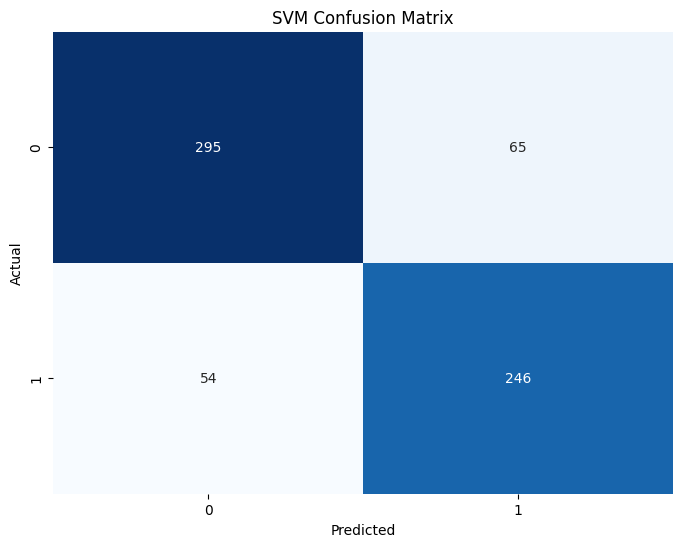


MLP Best Parameters: {'activation': 'tanh', 'alpha': 0.01, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant'}
MLP Best Score: 0.7770154102696797

MLP Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.80      0.81       360
           1       0.77      0.79      0.78       300

    accuracy                           0.80       660
   macro avg       0.80      0.80      0.80       660
weighted avg       0.80      0.80      0.80       660



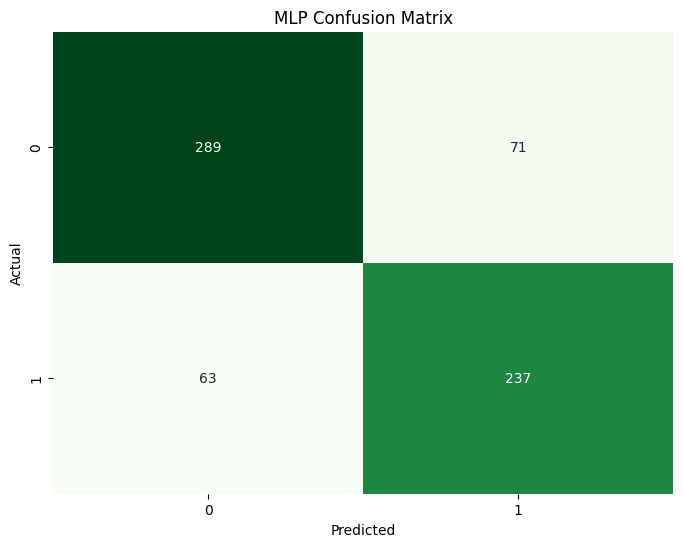

In [9]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# SVM Model with Grid Search
svm_param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['rbf', 'poly'],
    'gamma': ['scale', 'auto', 0.1, 1]
}
svm_grid = GridSearchCV(SVC(random_state=42), svm_param_grid, cv=5, n_jobs=-1)
svm_grid.fit(X_train_scaled, y_train)

print("SVM Best Parameters:", svm_grid.best_params_)
print("SVM Best Score:", svm_grid.best_score_)

# Predictions and evaluation for SVM
svm_pred = svm_grid.predict(X_test_scaled)
print("\nSVM Classification Report:")
print(classification_report(y_test, svm_pred))

# Plot SVM Confusion Matrix
plt.figure(figsize=(8, 6))
svm_cm = confusion_matrix(y_test, svm_pred)
sns.heatmap(svm_cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("SVM Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# MLP Model with Grid Search
mlp_param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive']
}
mlp_grid = GridSearchCV(MLPClassifier(random_state=42, max_iter=1000), mlp_param_grid, cv=5, n_jobs=-1)
mlp_grid.fit(X_train_scaled, y_train)

print("\nMLP Best Parameters:", mlp_grid.best_params_)
print("MLP Best Score:", mlp_grid.best_score_)

# Predictions and evaluation for MLP
mlp_pred = mlp_grid.predict(X_test_scaled)
print("\nMLP Classification Report:")
print(classification_report(y_test, mlp_pred))

# Plot MLP Confusion Matrix
plt.figure(figsize=(8, 6))
mlp_cm = confusion_matrix(y_test, mlp_pred)
sns.heatmap(mlp_cm, annot=True, fmt='d', cmap='Greens', cbar=False)
plt.title("MLP Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()



Random Forest Best Parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 50}
Random Forest Best Score: 0.7660248116842044

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.82      0.82       360
           1       0.79      0.78      0.78       300

    accuracy                           0.80       660
   macro avg       0.80      0.80      0.80       660
weighted avg       0.80      0.80      0.80       660



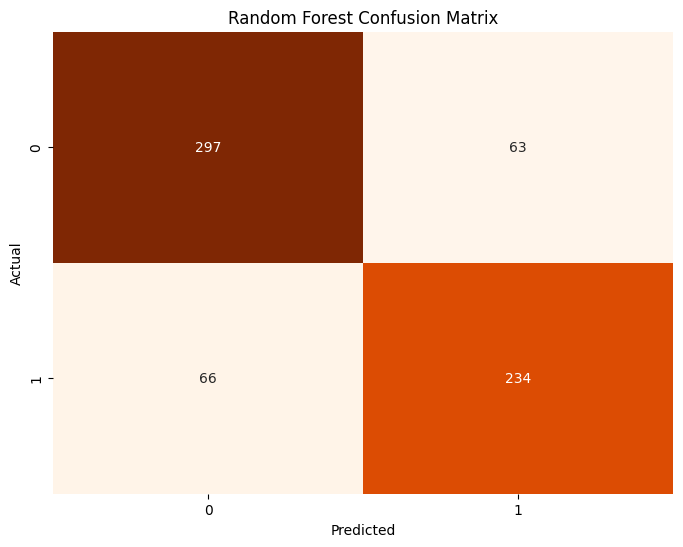

In [10]:
from sklearn.ensemble import RandomForestClassifier

# Random Forest Model with Grid Search
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
rf_grid = GridSearchCV(RandomForestClassifier(random_state=42), rf_param_grid, cv=5, n_jobs=-1)
rf_grid.fit(X_train_scaled, y_train)

print("\nRandom Forest Best Parameters:", rf_grid.best_params_)
print("Random Forest Best Score:", rf_grid.best_score_)

# Predictions and evaluation for Random Forest
rf_pred = rf_grid.predict(X_test_scaled)
print("\nRandom Forest Classification Report:")
print(classification_report(y_test, rf_pred))

# Plot Random Forest Confusion Matrix
plt.figure(figsize=(8, 6))
rf_cm = confusion_matrix(y_test, rf_pred)
sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Oranges', cbar=False)
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()



Ensemble Voting Classifier Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.84      0.85       360
           1       0.82      0.83      0.82       300

    accuracy                           0.84       660
   macro avg       0.83      0.84      0.84       660
weighted avg       0.84      0.84      0.84       660



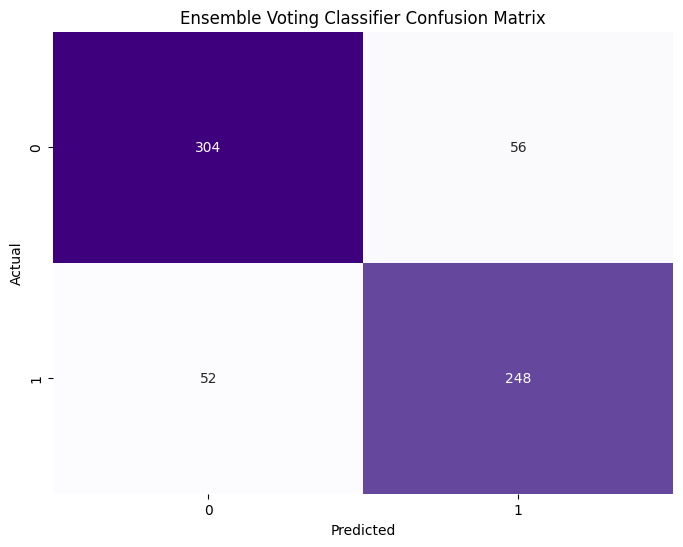

In [7]:
from sklearn.decomposition import PCA
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# SVM with extended parameter grid and RandomizedSearchCV
svm_param_dist = {
    'C': np.logspace(-3, 3, 10),
    'kernel': ['rbf', 'poly'],
    'gamma': ['scale', 'auto', 0.1, 1, 10]
}

svm_random = RandomizedSearchCV(SVC(random_state=42, probability=True), svm_param_dist, cv=5, n_jobs=-1, n_iter=20, random_state=42)
svm_random.fit(X_train, y_train)

# MLP with RandomizedSearchCV and extended parameter grid
mlp_param_dist = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50), (100, 100)],
    'activation': ['relu', 'tanh'],
    'alpha': np.logspace(-5, -1, 5),
    'learning_rate': ['constant', 'adaptive'],
    'solver': ['adam', 'sgd']
}
mlp_random = RandomizedSearchCV(MLPClassifier(random_state=42, max_iter=2000), mlp_param_dist, cv=5, n_jobs=-1, n_iter=20, random_state=42)
mlp_random.fit(X_train, y_train)


# Ensemble Voting Classifier with probability-enabled SVM, MLP, and Random Forest
rf = RandomForestClassifier(random_state=42, n_estimators=100)
voting_clf = VotingClassifier(estimators=[('svm', svm_random.best_estimator_), ('mlp', mlp_random.best_estimator_), ('rf', rf)], voting='soft')
voting_clf.fit(X_train, y_train)

# Evaluate Ensemble Model
voting_pred = voting_clf.predict(X_test)
print("\nEnsemble Voting Classifier Classification Report:")
print(classification_report(y_test, voting_pred))

# Plot Confusion Matrix for the Ensemble
plt.figure(figsize=(8, 6))
ensemble_cm = confusion_matrix(y_test, voting_pred)
sns.heatmap(ensemble_cm, annot=True, fmt='d', cmap='Purples', cbar=False)
plt.title("Ensemble Voting Classifier Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [5]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import local_binary_pattern, hog
from skimage.measure import shannon_entropy
import pywt
from tqdm import tqdm

# Set up output folder
output_folder = "output_images"
os.makedirs(output_folder, exist_ok=True)

# Function to save and display images or feature plots
def save_and_show_image(image, step_name, is_feature=False):
    """ Save and show images or feature plots. """
    file_path = os.path.join(output_folder, f"{step_name}.png")
    
    plt.figure(figsize=(6, 6))
    
    if is_feature:
        plt.plot(image)  # For feature array visualization
        plt.title(f"{step_name} - Feature Array")
    else:
        plt.imshow(image, cmap='gray' if len(image.shape) == 2 else None)
        plt.axis('off')
        plt.title(step_name)
    
    plt.savefig(file_path)
    plt.show()

# Sample image preprocessing
sample_image = preprocess_image(train_data[0])  # Make sure preprocess_image() is defined
save_and_show_image(sample_image, "1-Preprocessed Image")

# Convert to grayscale if not already
if len(sample_image.shape) == 3:
    gray_img = cv2.cvtColor(sample_image, cv2.COLOR_RGB2GRAY)
else:
    gray_img = sample_image

# LBP Texture Feature
lbp_image = local_binary_pattern(gray_img, 24, 3, method='uniform')
save_and_show_image(lbp_image, "2-LBP Texture Image")

# Shape Feature Visualization: Contours
_, binary = cv2.threshold(gray_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contour_img = cv2.cvtColor(binary, cv2.COLOR_GRAY2BGR)
cv2.drawContours(contour_img, contours, -1, (0, 255, 0), 2)
save_and_show_image(contour_img, "3-Contours - Shape Features")

# Gabor Filter Visualization
for i, theta in enumerate(np.arange(0, np.pi, np.pi / 8)):
    kernel = cv2.getGaborKernel((31, 31), sigma=4.0, theta=theta, lambd=10.0, gamma=0.5, psi=0)
    gabor_image = cv2.filter2D(gray_img, cv2.CV_8UC3, kernel)
    save_and_show_image(gabor_image, f"4-Gabor Filtered Image - Theta {i+1}")

# HOG Feature Visualization
hog_features, hog_image = hog(gray_img, orientations=8, pixels_per_cell=(16, 16),
                              cells_per_block=(1, 1), block_norm='L2-Hys', visualize=True)
save_and_show_image(hog_image, "5-HOG Features")

# Canny Edge Detection
canny_edges = cv2.Canny(gray_img, 100, 200)
save_and_show_image(canny_edges, "6-Canny Edge Detection")

# Sobel Edge Detection
sobelx = cv2.Sobel(gray_img, cv2.CV_64F, 1, 0, ksize=5)
sobely = cv2.Sobel(gray_img, cv2.CV_64F, 0, 1, ksize=5)
sobel_edges = cv2.magnitude(sobelx, sobely)
sobel_edges = cv2.normalize(sobel_edges, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
save_and_show_image(sobel_edges, "7-Sobel Edge Detection")

# Fractal Dimension
def fractal_dimension(img):
    """Calculate fractal dimension using box-counting method."""
    threshold = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY)[1]
    sizes = np.arange(2, min(threshold.shape) // 2, 2)
    counts = []
    for size in sizes:
        small = cv2.resize(threshold, (size, size), interpolation=cv2.INTER_NEAREST)
        counts.append(np.sum(small > 0))
    coeffs = np.polyfit(np.log(sizes), np.log(counts), 1)
    return -coeffs[0]

import numpy as np
import cv2
import matplotlib.pyplot as plt

def fractal_dimension(img, threshold=128):
    """Calculate the fractal dimension using the box-counting method."""
    # Convert the image to binary
    _, binary = cv2.threshold(img, threshold, 255, cv2.THRESH_BINARY)
    
    # Sizes for the box-counting method
    sizes = np.arange(2, min(binary.shape) // 2, 2)
    counts = []
    for size in sizes:
        # Resize and count the filled boxes
        resized_img = cv2.resize(binary, (size, size), interpolation=cv2.INTER_NEAREST)
        count = np.sum(resized_img > 0)
        counts.append(count)
    
    # Convert counts to a numpy array and filter out zero counts
    counts = np.array(counts)
    valid_sizes = sizes[counts > 0]
    valid_counts = counts[counts > 0]

    # Calculate the log of sizes and counts
    log_sizes = np.log(valid_sizes)
    log_counts = np.log(valid_counts)

    # Perform linear regression to estimate the fractal dimension
    if len(log_sizes) > 1 and len(log_counts) > 1:
        coeffs = np.polyfit(log_sizes, log_counts, 1)
        fractal_dim = -coeffs[0]
        return fractal_dim
    else:
        return None

# Example usage with a grayscale image (ensure gray_img is defined)
fractal_dim = fractal_dimension(gray_img)
if fractal_dim is not None:
    print("Fractal Dimension:", fractal_dim)
    plt.figure()
    plt.plot([fractal_dim], marker='o')
    plt.title("Fractal Dimension")
    plt.savefig("output_images/fractal_dimension.png")
    plt.show()
else:
    print("Fractal dimension calculation failed.")


def wavelet_transform(img):
    """Apply 2-level discrete wavelet transform and visualize coefficients."""
    coeffs2 = pywt.wavedec2(img, 'db1', level=2)
    wavelet_features = []
    for i, coeff in enumerate(coeffs2):
        if i == 0:
            # Approximation coefficients at the coarsest level
            cA = coeff
            wavelet_features.append(cA)
        else:
            # Horizontal, Vertical, and Diagonal detail coefficients
            cH, cV, cD = coeff
            wavelet_features.extend([cH, cV, cD])
    return wavelet_features


wavelet_coeffs = wavelet_transform(gray_img)
for i, coeff in enumerate(wavelet_coeffs):
    save_and_show_image(coeff, f"9-Wavelet Coefficient {i+1}")



def calculate_entropy(img):
    """Calculate Shannon entropy for the grayscale image."""
    if img.ndim == 3:  # Convert to grayscale if necessary
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    entropy_value = shannon_entropy(img)
    return entropy_value

# Calculate entropy and visualize
entropy_value = calculate_entropy(gray_img)
if entropy_value is not None:
    print("Entropy:", entropy_value)
    plt.figure()
    plt.plot([entropy_value], marker='o')
    plt.title("Entropy")
    plt.savefig("output_images/entropy.png")
    plt.show()
else:
    print("Entropy calculation failed.")



NameError: name 'preprocess_image' is not defined

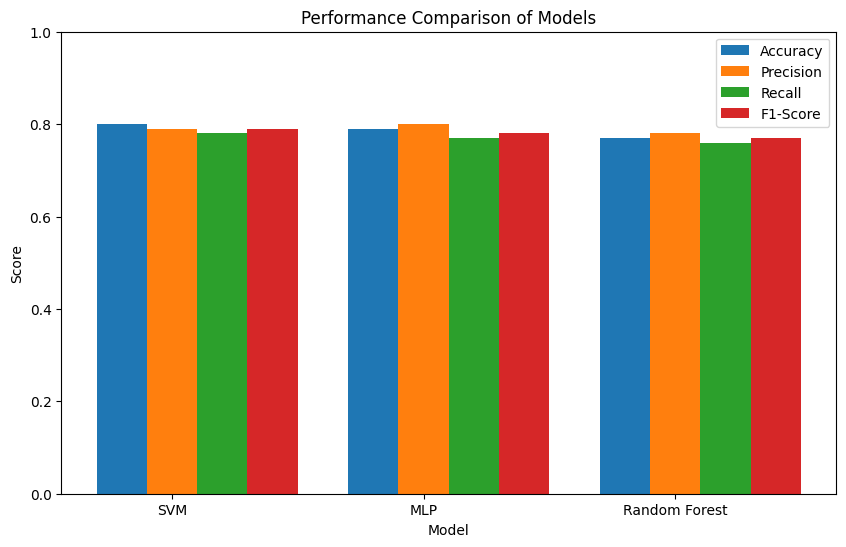

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Example performance metrics (replace these with your actual results)
# Fill in accuracy, precision, recall, and F1-score for each model
metrics = {
    'SVM': {'accuracy': 0.80, 'precision': 0.79, 'recall': 0.78, 'f1_score': 0.79},
    'MLP': {'accuracy': 0.79, 'precision': 0.80, 'recall': 0.77, 'f1_score': 0.78},
    'Random Forest': {'accuracy': 0.77, 'precision': 0.78, 'recall': 0.76, 'f1_score': 0.77}
}

# Extracting each metric for plotting
models = list(metrics.keys())
accuracy = [metrics[model]['accuracy'] for model in models]
precision = [metrics[model]['precision'] for model in models]
recall = [metrics[model]['recall'] for model in models]
f1_score = [metrics[model]['f1_score'] for model in models]

# Plotting the bar chart
bar_width = 0.2
index = np.arange(len(models))

plt.figure(figsize=(10, 6))

# Bars for each metric
plt.bar(index, accuracy, bar_width, label='Accuracy')
plt.bar(index + bar_width, precision, bar_width, label='Precision')
plt.bar(index + 2 * bar_width, recall, bar_width, label='Recall')
plt.bar(index + 3 * bar_width, f1_score, bar_width, label='F1-Score')

# Labels and Title
plt.xlabel('Model')
plt.ylabel('Score')
plt.title('Performance Comparison of Models')
plt.xticks(index + bar_width, models)
plt.ylim([0, 1])
plt.legend()

# Display the plot
plt.show()
